In [72]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime, timedelta
import os

# Parameters
default_start_date = datetime(2013, 1, 1)
end_date = datetime.today()
chunk_size_days = 90
ticker = "^GSPC"
output_file = "sp500_bulk_data.csv"

# Determine the starting point
if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
    try:
        existing_df = pd.read_csv(output_file, parse_dates=["Date"])
        last_date = existing_df["Date"].max()
        start_date = last_date + timedelta(days=1)
        print(f"📁 Continuing from last date in file: {last_date.date()} → Start from: {start_date.date()}")
    except Exception as e:
        print(f"⚠️ Error reading file. Starting fresh: {e}")
        start_date = default_start_date
else:
    print("🆕 No existing file or empty file. Starting fresh.")
    start_date = default_start_date

# Main download loop
current = start_date
first_chunk = not os.path.exists(output_file)

while current < end_date:
    chunk_end = min(current + timedelta(days=chunk_size_days), end_date)
    print(f"⏳ Downloading from {current.date()} to {chunk_end.date()}")

    try:
        df = yf.download(
            ticker,
            start=current.strftime("%Y-%m-%d"),
            end=chunk_end.strftime("%Y-%m-%d"),
            interval="1d",
            progress=False
        )

        if not df.empty:
            df.reset_index(inplace=True)
            df.columns.name = None
            df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

            df.to_csv(output_file, mode="a", index=False, header=first_chunk)
            first_chunk = False
            print(f"✅ Saved {len(df)} rows.")
        else:
            print("⚠️ No data returned for this chunk.")

    except Exception as e:
        print(f"❌ Error downloading: {e}")

    current = chunk_end
    time.sleep(5)

print("🎉 All chunks downloaded and saved to:", output_file)


📁 Continuing from last date in file: 2025-04-21 → Start from: 2025-04-22
⏳ Downloading from 2025-04-22 to 2025-04-22
✅ Saved 1 rows.
🎉 All chunks downloaded and saved to: sp500_bulk_data.csv


In [73]:
data = pd.read_csv("sp500_bulk_data.csv", index_col=0, parse_dates=True)
data = data.iloc[1:]  # Drop junk row

data.to_csv("sp500_bulk_data.csv")

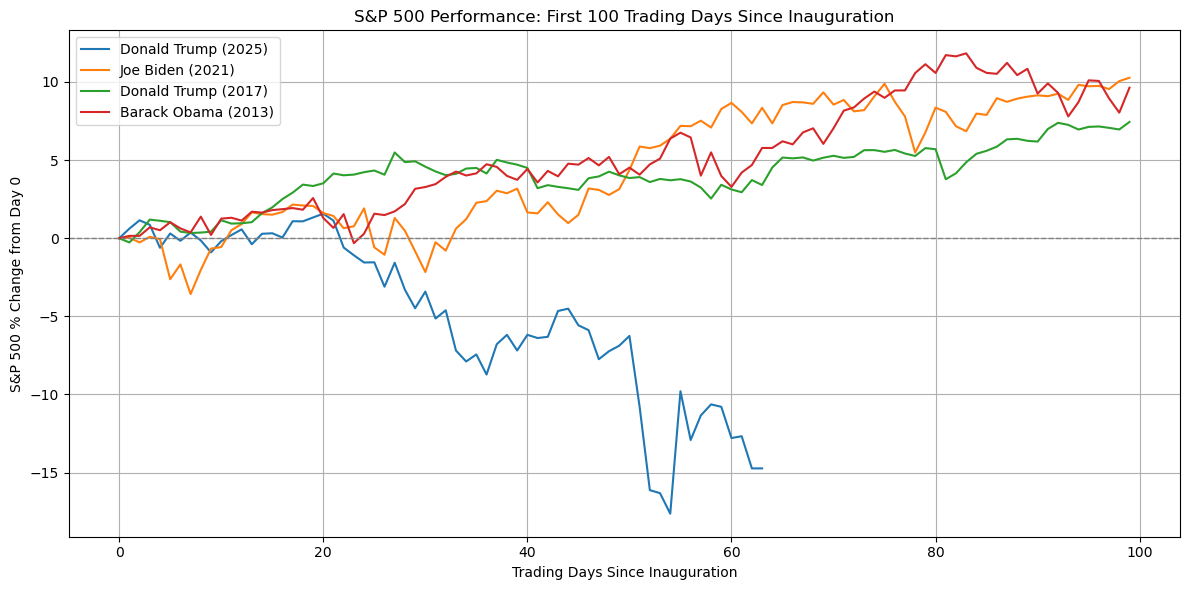

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV and ensure datetime index
data = pd.read_csv("sp500_bulk_data.csv", index_col=0, parse_dates=True)
data.index = pd.to_datetime(data.index)  # 🔧 FIX: make index datetime

# Inauguration dates of last 4 presidents
inauguration_dates = {
    "Donald Trump (2025)": "2025-01-20",
    "Joe Biden (2021)": "2021-01-20",
    "Donald Trump (2017)": "2017-01-20",
    "Barack Obama (2013)": "2013-01-20"
}

# Get 100 trading days of data starting from a given inauguration date
def get_sp500_data_from_csv(start_date, days=100):
    start = pd.to_datetime(start_date)
    df_slice = data.loc[start:].head(days).copy()
    df_slice['Pct Change'] = (df_slice['Close'] / df_slice['Close'].iloc[0] - 1) * 100
    df_slice.reset_index(inplace=True)
    return df_slice

# Get the data for each president
sp500_dfs = {
    president: get_sp500_data_from_csv(date)
    for president, date in inauguration_dates.items()
}

# Plotting
plt.figure(figsize=(12, 6))
for president, df in sp500_dfs.items():
    plt.plot(range(len(df)), df['Pct Change'], label=president)  # X-axis is day count

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("S&P 500 Performance: First 100 Trading Days Since Inauguration")
plt.xlabel("Trading Days Since Inauguration")
plt.ylabel("S&P 500 % Change from Day 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


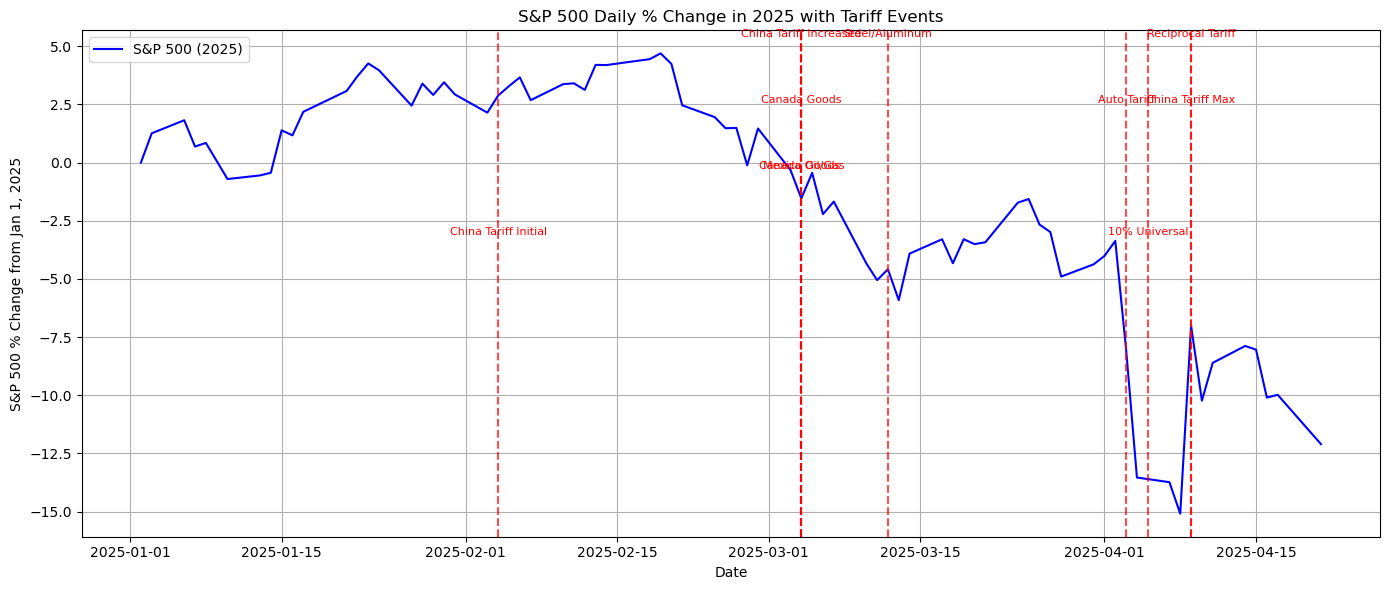

In [16]:
# Filter data for 2025 only
sp500_2025 = data[(data.index >= "2025-01-01") & (data.index <= "2025-12-31")].copy()
sp500_2025['Pct Change'] = (sp500_2025['Close'] / sp500_2025['Close'].iloc[0] - 1) * 100

# Tariff events and labels
tariff_events = [
    {"label": "Steel/Aluminum", "date": "2025-03-12"},
    {"label": "Auto Tariff", "date": "2025-04-03"},
    {"label": "Auto Parts", "date": "2025-05-03"},
    {"label": "10% Universal", "date": "2025-04-05"},
    {"label": "Reciprocal Tariff", "date": "2025-04-09"},
    {"label": "Canada Goods", "date": "2025-03-04"},
    {"label": "Canada Oil/Gas", "date": "2025-03-04"},
    {"label": "China Tariff Initial", "date": "2025-02-04"},
    {"label": "China Tariff Increased", "date": "2025-03-04"},
    {"label": "China Tariff Max", "date": "2025-04-09"},
    {"label": "Mexico Goods", "date": "2025-03-04"},
]

# Convert string dates to datetime
for event in tariff_events:
    event["datetime"] = pd.to_datetime(event["date"])

# Plot the S&P 500 percentage change
plt.figure(figsize=(14, 6))
plt.plot(sp500_2025.index, sp500_2025['Pct Change'], label="S&P 500 (2025)", color="blue")

# Add vertical lines for tariff events with staggered horizontal labels and bigger gaps
y_min, y_max = plt.ylim()
label_spacing = 0.5  # bigger gap between label levels
num_levels = 4

label_y_positions = [y_max * (0.95 - label_spacing * (i % num_levels)) for i in range(len(tariff_events))]

for i, event in enumerate(tariff_events):
    if sp500_2025.index.min() <= event["datetime"] <= sp500_2025.index.max():
        plt.axvline(event["datetime"], color='red', linestyle='--', alpha=0.7)
        plt.text(event["datetime"], label_y_positions[i], event["label"],
                 rotation=0, ha='center', fontsize=8, color='red')

# Final formatting
plt.title("S&P 500 Daily % Change in 2025 with Tariff Events")
plt.xlabel("Date")
plt.ylabel("S&P 500 % Change from Jan 1, 2025")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
